In [1]:
#### skip warning if any
import warnings
warnings.filterwarnings('ignore')

In [2]:
#### import all required lib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [5]:
df_test.head(2)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...


In [6]:
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# we can find that only fake news are having text as null, so we can drop respective data with other column containing null values 
df_train[df_train.isnull()['title']==True]['label'].value_counts()

1    558
Name: label, dtype: int64

In [8]:
df_train['title'].fillna('Fake Fake Fake',inplace=True)

In [9]:
df_train.isnull().sum()

id           0
title        0
author    1957
text        39
label        0
dtype: int64

In [10]:
df_test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [11]:
df_test['title'].fillna('Fake Fake Fake',inplace=True)

In [12]:
df_test.isnull().sum()

id          0
title       0
author    503
text        7
dtype: int64

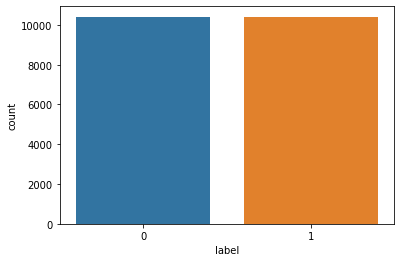

In [13]:
##### we will try to visualize some distribution, so using countplot data is not imbalanced
sns.countplot(df_train['label'])

In [14]:
#### import NLP specific data pre-processing libraries
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import re

In [15]:
#### function for cleaning text like remove punctuations, digits and other than alphabet word
def text_analyzer(messages):
    porter = PorterStemmer()
    clean_corpus = []
    
    for i in range(len(messages)):
        
        text = messages.iloc[i]
        clean_text = re.sub('[^a-zA-Z]',' ',text)
        
        clean_text = clean_text.lower()
        clean_text = clean_text.split()
        
        clean_text = [porter.stem(word) for word in clean_text if word not in stopwords.words('english')]
        clean_text = ' '.join(clean_text)
        
        clean_corpus.append(clean_text)
        
    return clean_corpus
    

In [16]:
print(len(df_train))


20800


In [17]:
train_clean_messages = text_analyzer(df_train['title'])

In [18]:
train_clean_messages[:10]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'life life luxuri elton john favorit shark pictur stare long transcontinent flight',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'excerpt draft script donald trump q ampa black church pastor new york time',
 'back channel plan ukrain russia courtesi trump associ new york time']

In [19]:
#### we will work on Word embedding now
#### declare variable vocabulary size
voc_size = 5000

In [20]:
max_len = 0
for msg in train_clean_messages:
    msg_len = len(msg.split())
    if msg_len > max_len:
        max_len=msg_len

print('Max Sentence lenght in corpus is',max_len)

Max Sentence lenght in corpus is 47


In [21]:
# so we will set sentence lenght to 50
sent_len=50
# we will set dimention as 40
dim=40 

In [22]:
#### we will import some packages which are required for one hot representation
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

Using TensorFlow backend.


In [23]:
def get_embedded_corpus(vocsize,sentlen,message):
    try:
        one_hot_corpus = [one_hot(word,vocsize) for word in message]
        padded_corpus = pad_sequences(one_hot_corpus,padding='pre',maxlen=sentlen)
    except e:
        print('exception is',e)
    finally:
        return padded_corpus

In [24]:
cleaned_word_corpus=get_embedded_corpus(voc_size,sent_len,train_clean_messages)

In [25]:
len(cleaned_word_corpus)

20800

In [26]:
cleaned_word_corpus[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 2879,   55, 3082, 3503,
         937, 3246, 3577, 4736, 4345, 1468],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3773,
        4490, 1980, 3794, 3982, 1243, 3392]])

In [27]:
#### now we will create neural network for text classification
#### import required lib for the same
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout

In [28]:
model = Sequential()
model.add(Embedding(voc_size,dim,input_length=sent_len))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 40)            200000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [30]:
print('Shape of embedded corpus',cleaned_word_corpus.shape)
print('Type of embedded corpus',type(cleaned_word_corpus))

Shape of embedded corpus (20800, 50)
Type of embedded corpus <class 'numpy.ndarray'>


In [31]:
X=cleaned_word_corpus
y=df_train['label']

In [32]:
print('Shape of label',y.shape)
print('Type of label',type(y))

Shape of label (20800,)
Type of label <class 'pandas.core.series.Series'>


In [33]:
y = np.array(y)
print(y[:5])
print('Type of label',type(y))

[1 0 1 1 1]
Type of label <class 'numpy.ndarray'>


In [34]:
#### we will now train and fit the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [35]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=256)


Train on 13936 samples, validate on 6864 samples
Epoch 1/10
13936/13936 [==============================] - 34s 2ms/step - loss: 0.5276 - accuracy: 0.7423 - val_loss: 0.3062 - val_accuracy: 0.8807
Epoch 2/10
13936/13936 [==============================] - 29s 2ms/step - loss: 0.2153 - accuracy: 0.9141 - val_loss: 0.1982 - val_accuracy: 0.9205
Epoch 3/10
13936/13936 [==============================] - 29s 2ms/step - loss: 0.1367 - accuracy: 0.9484 - val_loss: 0.1925 - val_accuracy: 0.9263
Epoch 4/10
13936/13936 [==============================] - 28s 2ms/step - loss: 0.1028 - accuracy: 0.9628 - val_loss: 0.1972 - val_accuracy: 0.9250
Epoch 5/10
13936/13936 [==============================] - 29s 2ms/step - loss: 0.0811 - accuracy: 0.9715 - val_loss: 0.2143 - val_accuracy: 0.9253
Epoch 6/10
13936/13936 [==============================] - 30s 2ms/step - loss: 0.0656 - accuracy: 0.9785 - val_loss: 0.2402 - val_accuracy: 0.9238
Epoch 7/10
13936/13936 [==============================] - 24s 2ms/st

In [36]:
#### now we will try to fit this model on test data
submission = pd.read_csv('submit.csv')
submission.head(5)

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [37]:
print('length of submission df',len(submission))
print('length of test df (null already removed)',len(df_test))

length of submission df 5200
length of test df (null already removed) 5200


In [38]:
test_df = pd.merge(df_test,submission,how='inner')[['title','label']]

In [39]:
test_df.head(5)

,title,label
0,"Specter of Trump Loosens Tongues, if Not Purse...",0
1,Russian warships ready to strike terrorists ne...,1
2,#NoDAPL: Native American Leaders Vow to Stay A...,0
3,"Tim Tebow Will Attempt Another Comeback, This ...",1
4,Keiser Report: Meme Wars (E995),1


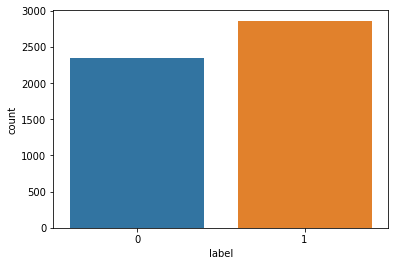

In [40]:
sns.countplot(test_df['label'])

In [41]:
test_clean_messages = text_analyzer(test_df['title'])

In [55]:
max_len = 0
for msg in test_clean_messages:
    msg_len = len(msg.split())
    if msg_len > max_len:
        max_len=msg_len

print('Max Sentence lenght in corpus is testing data',max_len)

Max Sentence lenght in corpus is testing data 29


In [56]:
# so we can set sentence lenght as set in training
cleaned_test_word_corpus=get_embedded_corpus(voc_size,sent_len,test_clean_messages)

In [57]:
cleaned_test_word_corpus[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  480, 1593, 2177, 1454, 4689,
        1554, 4021, 1455, 4276, 3408, 3406],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  280,
        3913,  502, 1087, 4752, 4877, 1858],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 3636, 3586, 1383, 2490,
        2182, 1768, 21

In [58]:
y_pred = model.predict_classes(cleaned_test_word_corpus)
#y_pred = model.predict_classes(X_test)

In [59]:
len(y_pred)

5200

In [60]:
real_test_y=list(test_df['label'])

In [61]:
real_test_y[:5]

[0, 1, 0, 1, 1]

In [62]:
y_pred=[int(i) for i in y_pred]

In [63]:
y_pred[:5]

[0, 1, 1, 0, 1]

In [64]:
##### we will check classification report and confusion matrix for calculating accuracy
from sklearn.metrics import classification_report,confusion_matrix

In [65]:
print(classification_report(real_test_y,y_pred))
#print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      2339
           1       0.70      0.65      0.67      2861

    accuracy                           0.65      5200
   macro avg       0.65      0.65      0.65      5200
weighted avg       0.66      0.65      0.65      5200



In [66]:
print(confusion_matrix(real_test_y,y_pred))

[[1540  799]
 [1006 1855]]


In [70]:
my_submission = df_test[['id']]
my_submission['label'] = y_pred
my_submission.to_csv('my_submission_1.csv', index = False)

In [71]:
import pickle
file=open('FakeClassifier.pkl','wb')
pickle.dump(model,file)

file.close()